In [2]:
import pandas as pd
import seaborn as sns

sns.set()

In [3]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df['Question ID'] = pd.Categorical(df['Question ID'],
                                   categories=sorted(df['Question ID'].value_counts().keys()),
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)
df["Given-Expected Answer Pair"] = pd.Categorical(df["Given-Expected Answer Pair"],
                                                 categories=sorted(df["Given-Expected Answer Pair"].value_counts().keys()),
                                                 ordered=True)

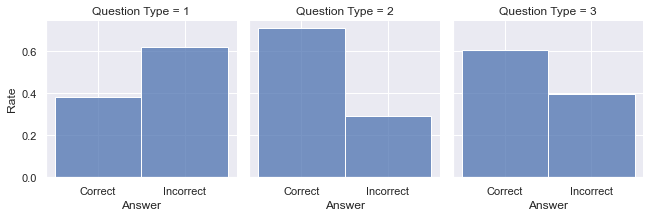

In [4]:
g = sns.FacetGrid(df, col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
graph.savefig('qType.png')

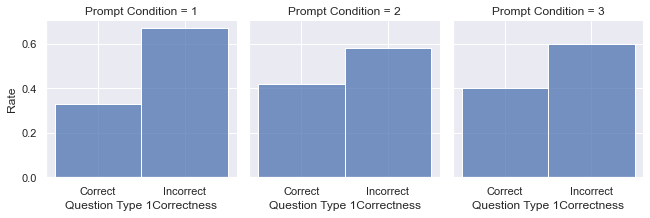

In [12]:
g = sns.FacetGrid(df[df["Question Type"] == 1], col = "Prompt Condition")
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Question Type 1Correctness")
graph.set_ylabels("Rate")
graph.savefig('condition1.png')


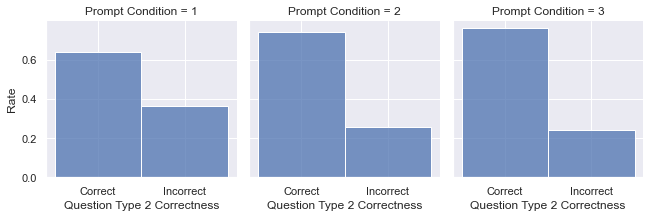

In [10]:
g = sns.FacetGrid(df[df["Question Type"] == 2], col = "Prompt Condition")
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Question Type 2 Correctness")
graph.set_ylabels("Rate")
graph.savefig('condition2.png')

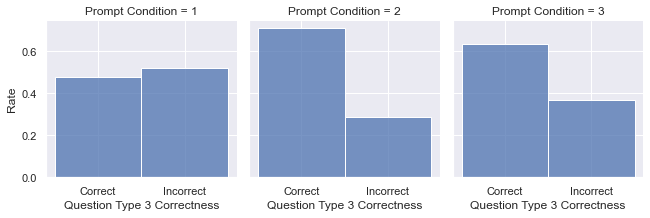

In [11]:
g = sns.FacetGrid(df[df["Question Type"] == 3], col = "Prompt Condition")
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Question Type 3 Correctness")
graph.set_ylabels("Rate")
graph.savefig('condition3.png')

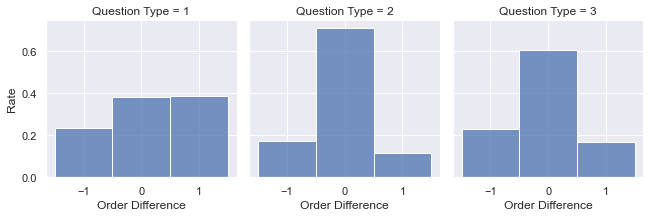

In [13]:
g = sns.FacetGrid(df, col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Order Difference", stat="probability")
graph.set_xlabels("Order Difference")
graph.set_ylabels("Rate")
graph.savefig('order.png')


In [14]:
df1 = pd.read_csv('output.csv')
df1["Correctness"] = df1["Correctness"].map({0: "Incorrect", 1:"Correct"})
df1['Correctness'] = pd.Categorical(df1['Correctness'],  categories=["Correct", "Incorrect"],
                                   ordered=True)

In [ ]:
t1 = pd.DataFrame()
one = df1.loc[df1['Question Type'] == 1]
t1 = t1.append(one)
t1 = t1.reset_index(drop=True)
g = sns.FacetGrid(t1, col="Question ID", col_wrap=6)
graph = g.map_dataframe(sns.histplot, x="Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
graph.savefig('type1.png')

KeyboardInterrupt: 

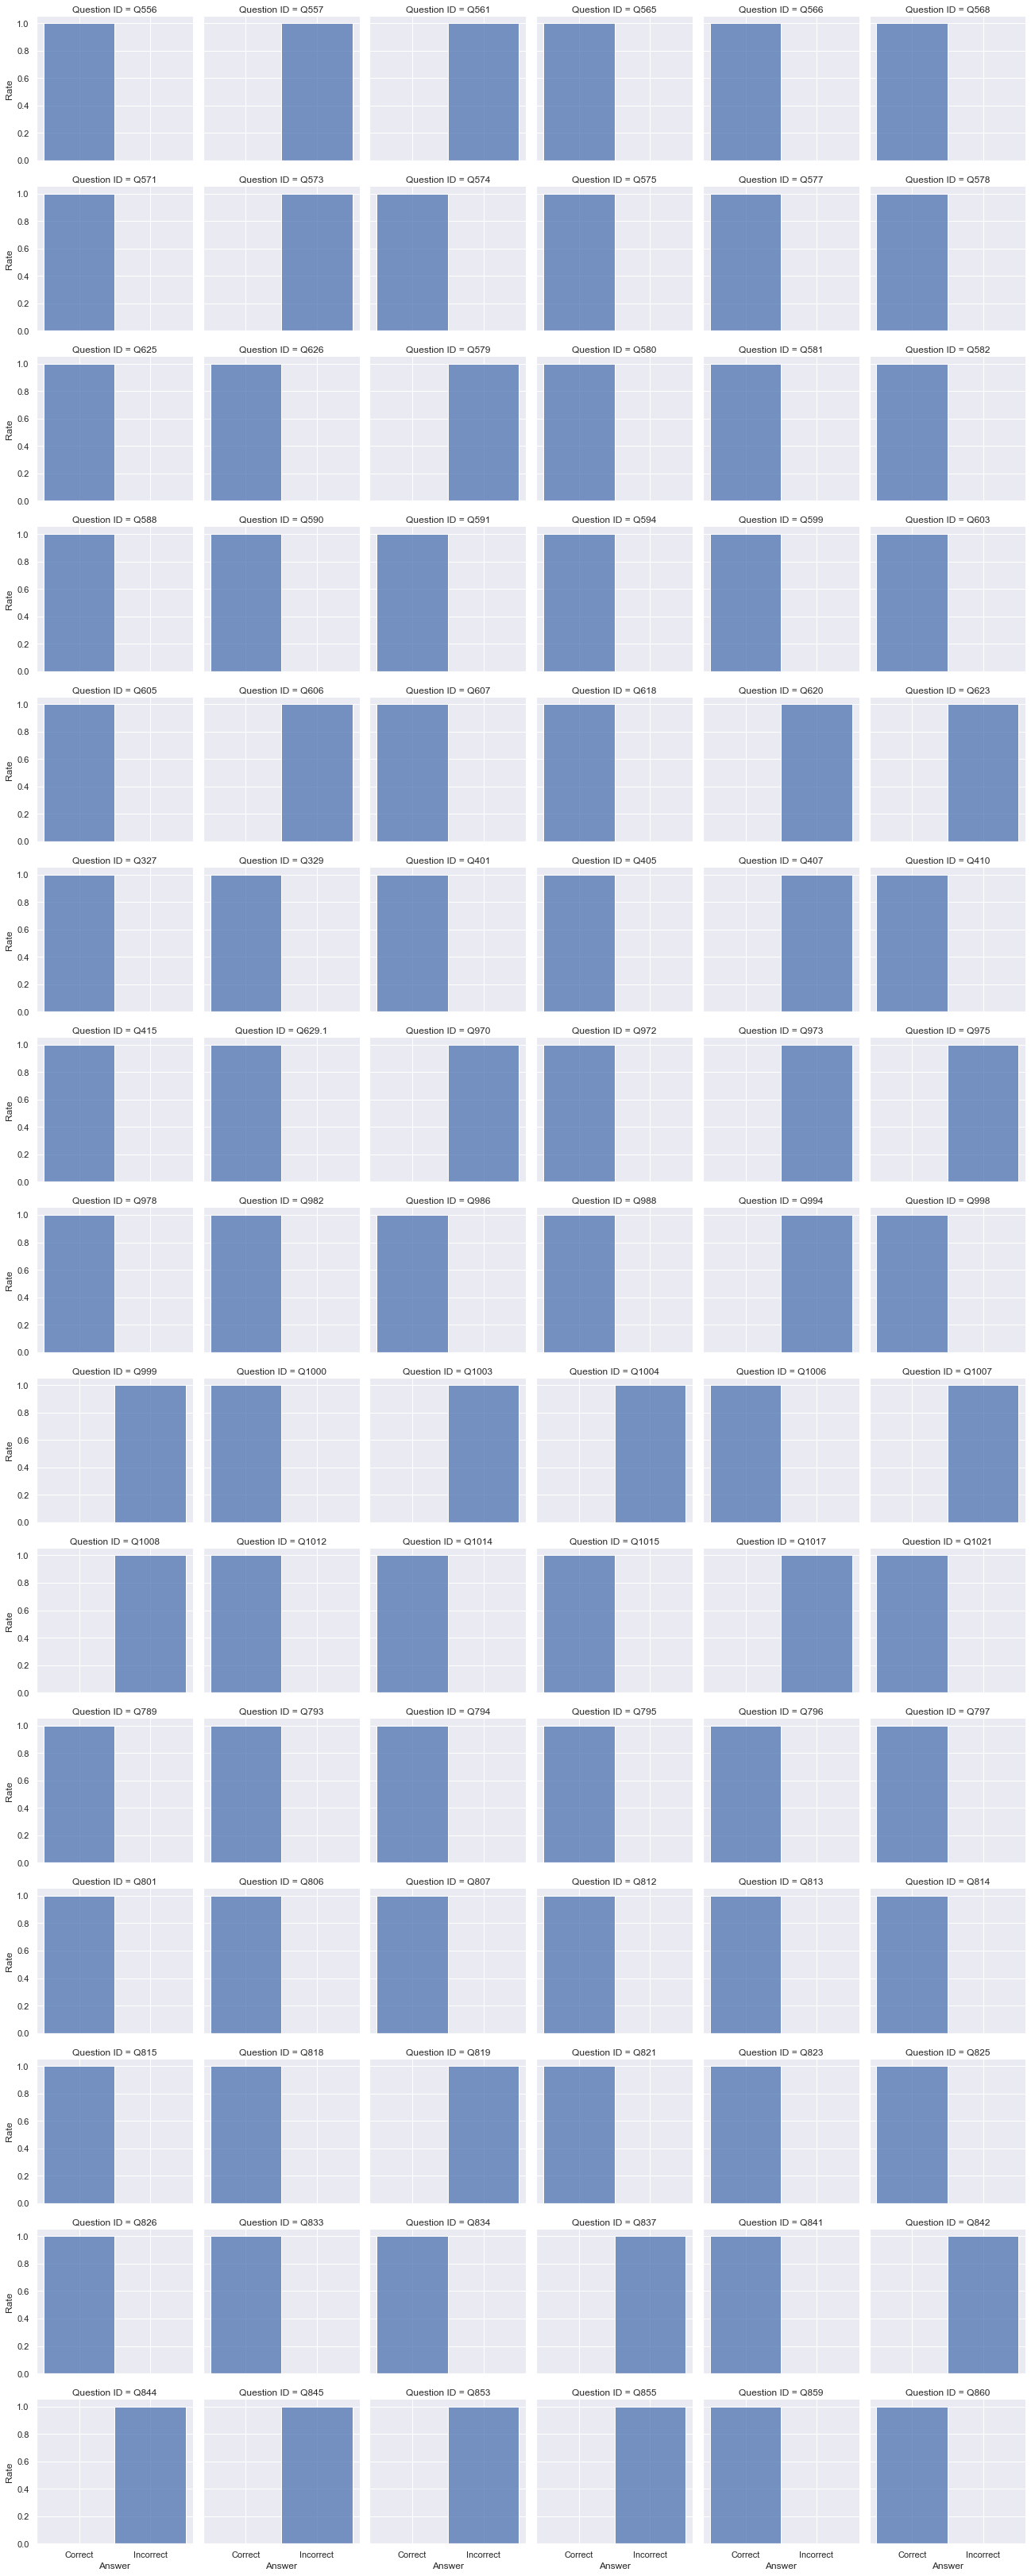

In [24]:
t2 = pd.DataFrame()
two = df1.loc[df['Question Type'] == 2]
t2 = t2.append(two)
t2 = t2.reset_index(drop=True)
g = sns.FacetGrid(t2, col="Question ID", col_wrap=6)
graph = g.map_dataframe(sns.histplot, x="Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
graph.savefig('type2.png')


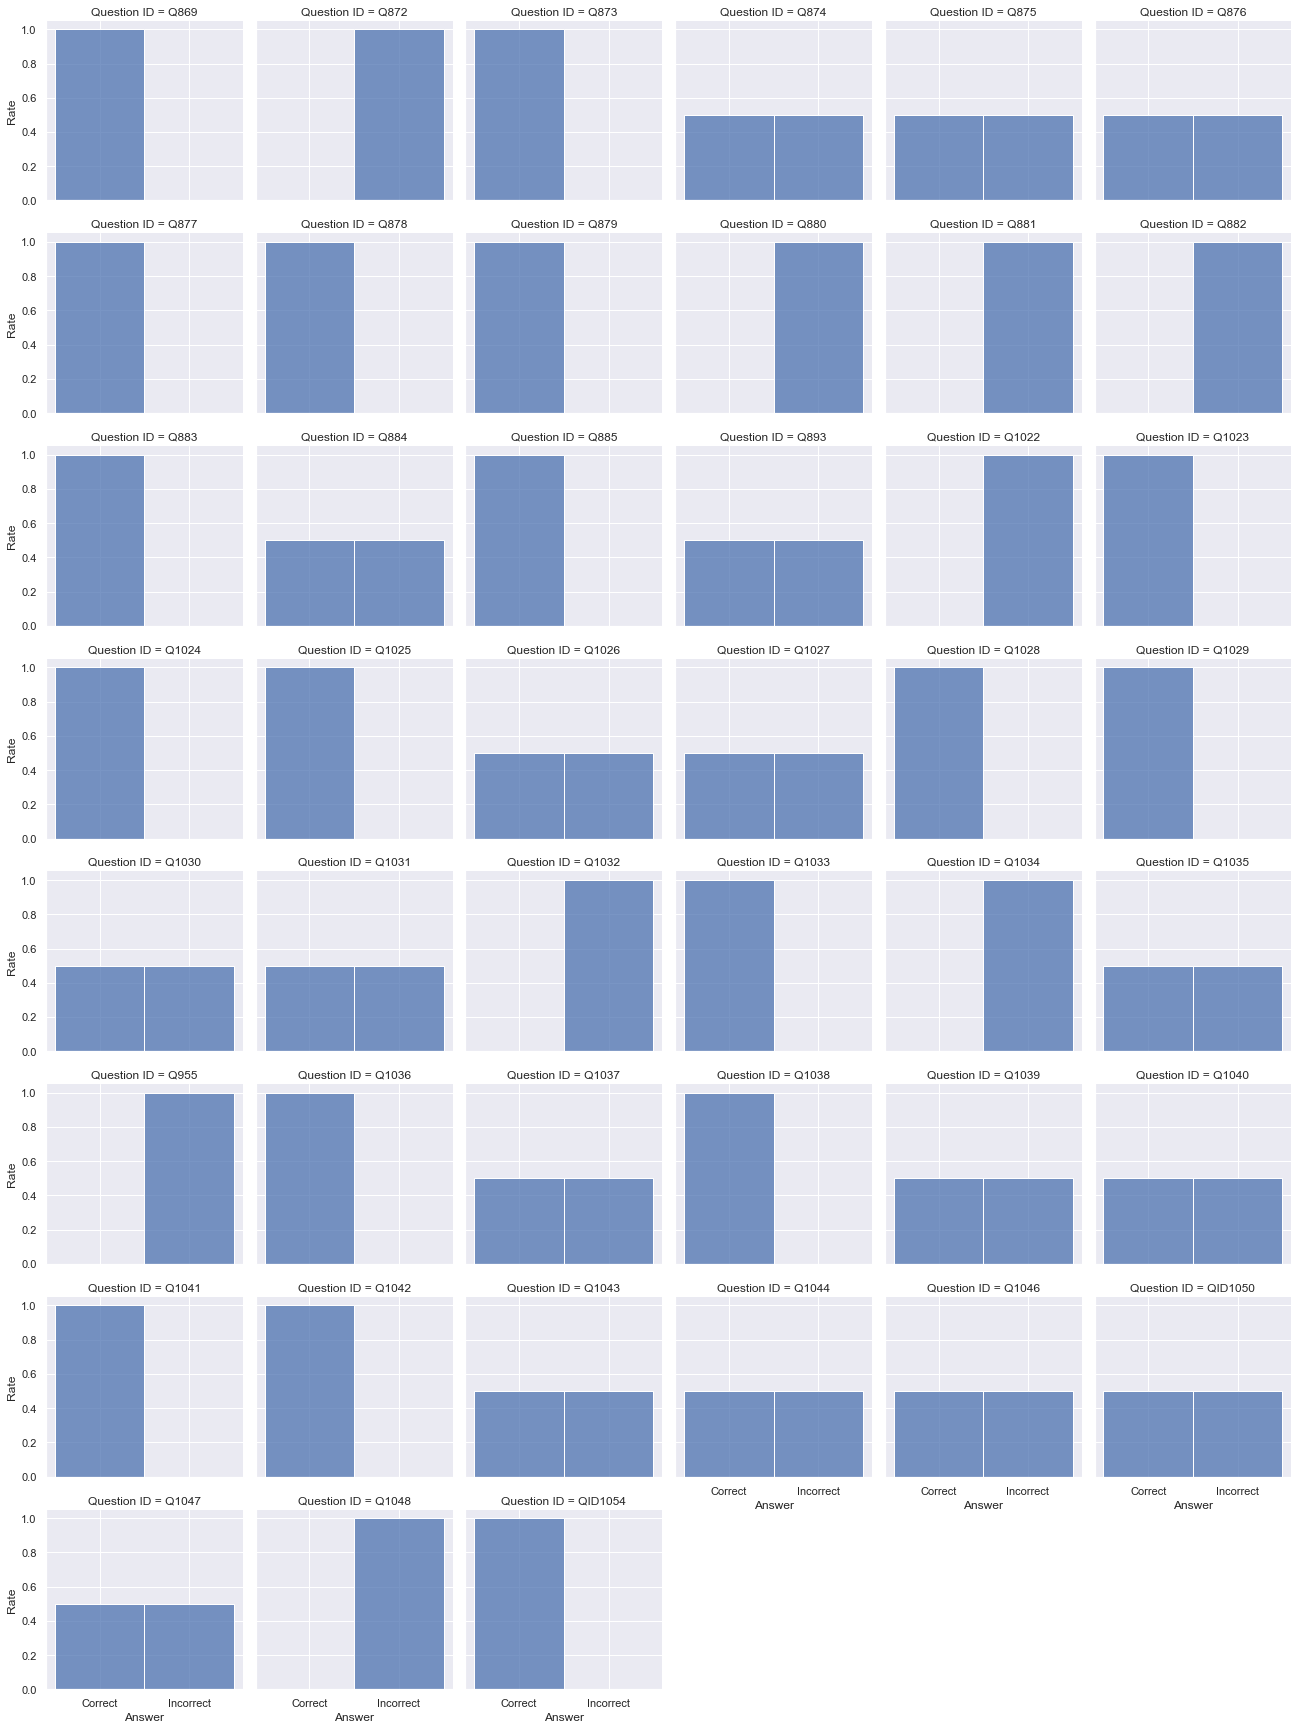

In [25]:
t3 = pd.DataFrame()
three = df1.loc[df1['Question Type'] == 3]
t3 = t3.append(three)
t3 = t3.reset_index(drop=True)
g = sns.FacetGrid(t3, col="Question ID", col_wrap=6)
graph = g.map_dataframe(sns.histplot, x="Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
graph.savefig('type3.png')

In [58]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)


Text(0.5, 0.98, 'Given-Expected Answer Pair')

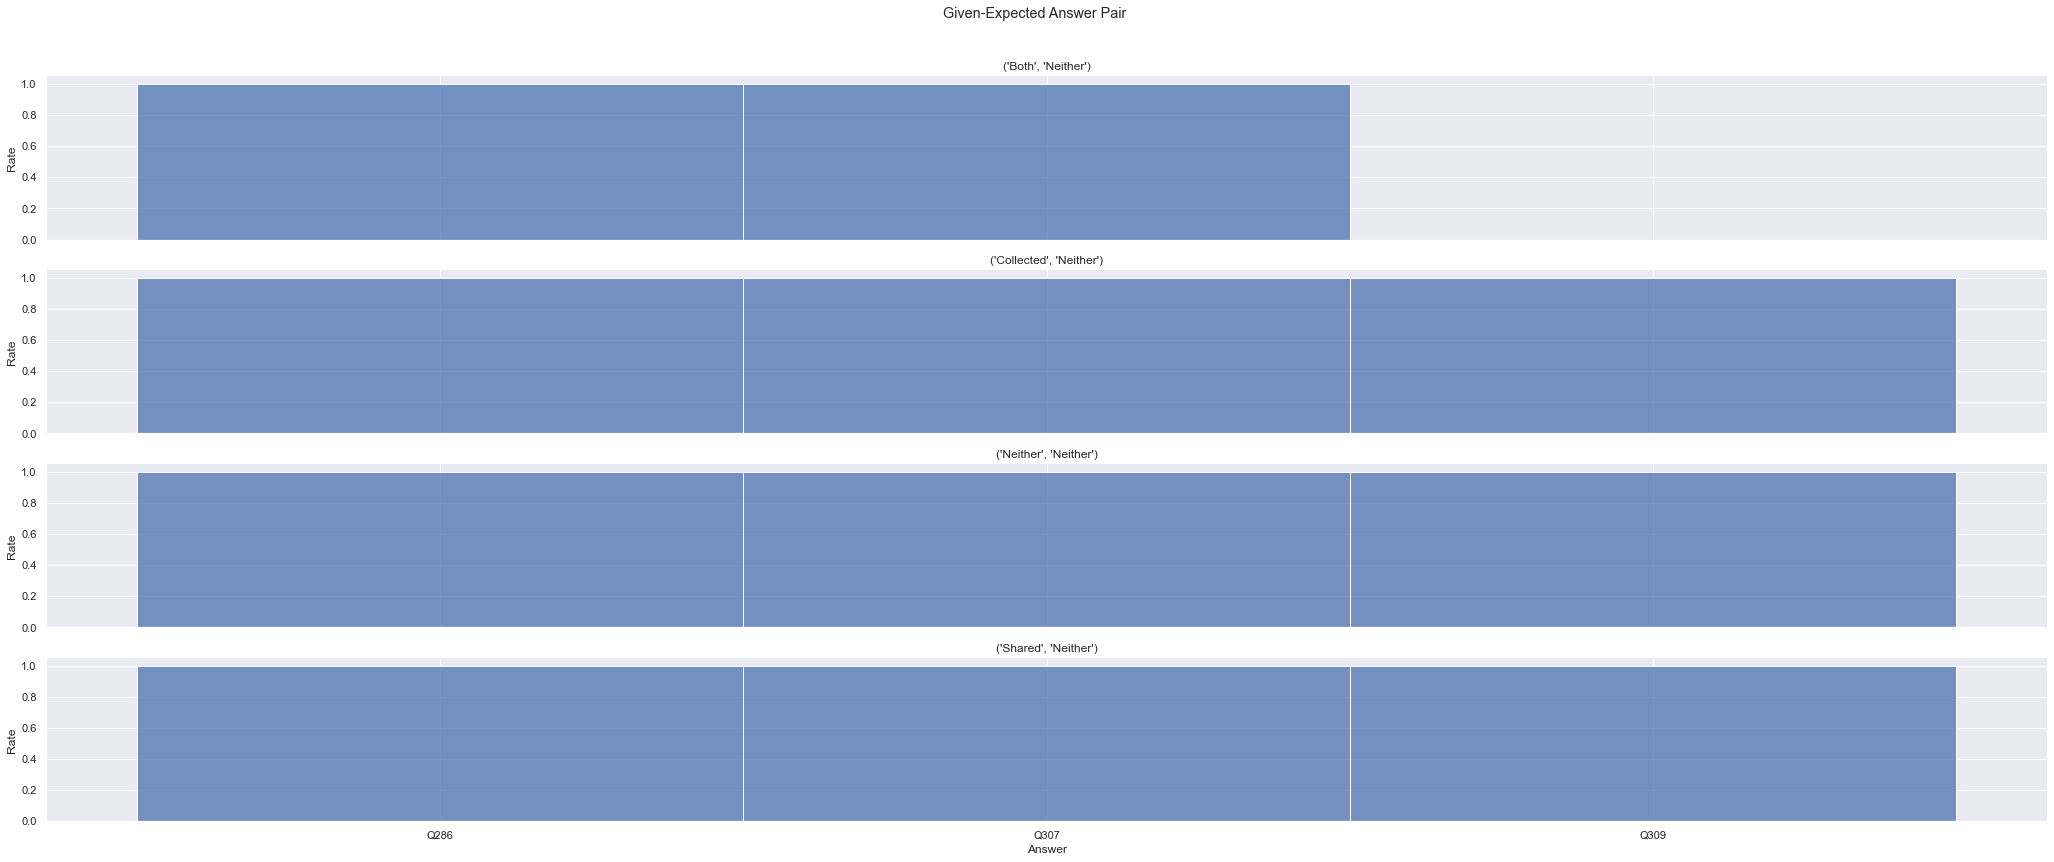

In [59]:
g = sns.FacetGrid(df[df["Correct Answer"] == "Neither"], col = "Given-Expected Answer Pair", col_wrap=1, aspect=9.5,
                 col_order=sorted(df[df["Correct Answer"] == "Neither"]["Given-Expected Answer Pair"].value_counts().keys()))
graph = g.map_dataframe(sns.histplot, x = "Question ID", stat="count")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a title for the entire plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Given-Expected Answer Pair")

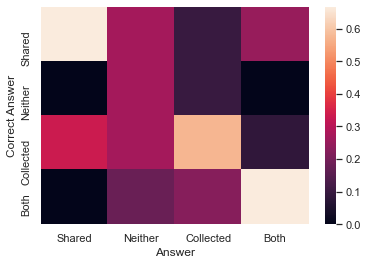

In [22]:
t1 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t1 = t1[t1["Question Type"] == 1]
t1 = t1.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t1.loc[:, "Correct Answer"]
actualAnswers = t1.loc[:, "Answer"]
answerPairs = dict()
rowNames = set()
for (i,j) in zip(correctAnswers, actualAnswers):
    rowNames.add(i)
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(j, i)] = answerPairs.get((j, i), 0) + 1
#create ratios for actual/correct answers
for (actual, correct) in answerPairs:
    answerPairs[(actual, correct)] = answerPairs[(actual, correct)] / correctTotals[correct]
rowNames = list(rowNames)
type1 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type1.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type1.at[rowNames[i], rowNames[j]] = 0
type1 = type1.astype(float)
g = sns.heatmap(type1)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
g.figure.savefig("q1.png")

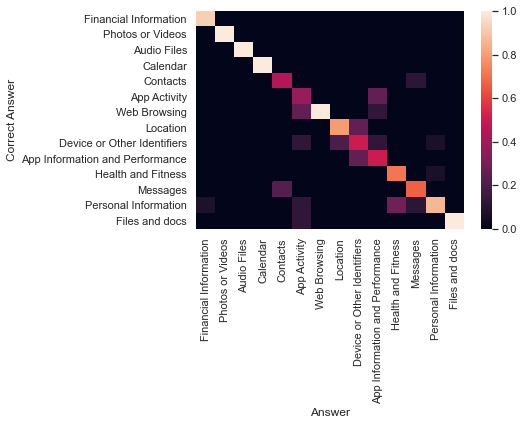

In [26]:
t2 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t2 = t2[t2["Question Type"] == 2]
t2 = t2.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t2.loc[:, "Correct Answer"]
actualAnswers = t2.loc[:, "Answer"]
answerPairs = dict()
rowNames = set()
for (i,j) in zip(correctAnswers, actualAnswers):
    rowNames.add(i)
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(j, i)] = answerPairs.get((j, i), 0) + 1
#create ratios for actual/correct answers
for (actual, correct) in answerPairs:
    answerPairs[(actual, correct)] = answerPairs[(actual, correct)] / correctTotals[correct]
rowNames = list(rowNames)
type2 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type2.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type2.at[rowNames[i], rowNames[j]] = 0
type2 = type2.astype(float)
g = sns.heatmap(type2)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
g.figure.savefig("q2.png", bbox_inches = "tight")


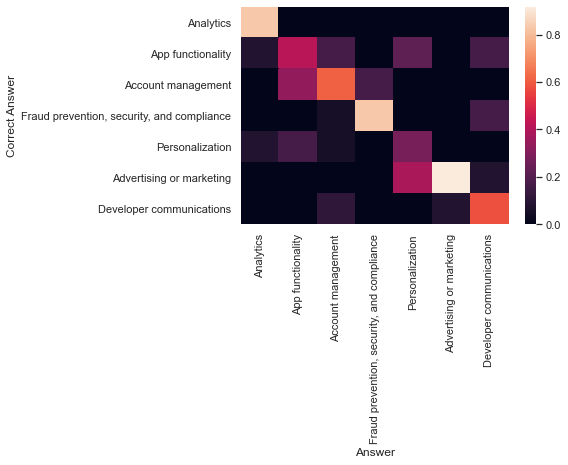

In [27]:
t3 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t3 = t3[t3["Question Type"] == 3]
t3 = t3.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t3.loc[:, "Correct Answer"]
actualAnswers = t3.loc[:, "Answer"]
answerPairs = dict()
rowNames = set()
for (i,j) in zip(correctAnswers, actualAnswers):
    rowNames.add(i)
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(j, i)] = answerPairs.get((j, i), 0) + 1
#create ratios for actual/correct answers
for (actual, correct) in answerPairs:
    answerPairs[(actual, correct)] = answerPairs[(actual, correct)] / correctTotals[correct]
rowNames = list(rowNames)
type3 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type3.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type3.at[rowNames[i], rowNames[j]] = 0
type3 = type3.astype(float)
g = sns.heatmap(type3)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
g.figure.savefig("q3.png", bbox_inches = "tight")
